# Cleaning and Analyzing the Massachusetts School Districts data

Massachusetts publishes various data about each school and school district for each year. This data set includes kindergarten-through-12th-grade school district summary statistics for ~2014, including results for standardized tests like the MCAS and SAT, as well as staff retention, expenditures, and demographic data.

In [1]:
%matplotlib inline
import matplotlib
import bdbcontrib
from bdbcontrib import Population

from ma_schools import datafile

Unlike the Satellites dataset, all but the district names are essentially numeric values.

You can see the data collected in a spreadsheet here: https://docs.google.com/spreadsheets/d/1vTy1kcfnn7629j5eMpuKWbwxgYcfI23DvYkaVUf5G0E/edit#gid=1798241546
The source web pages and the query parameters used to search them are listed in the "Provenance" tab.

Let's make our first generative population model:

In [2]:
schools0 = Population('schools0', csv_path=datafile, bdb_path='schools0.bdb')

BQL [SELECT * FROM bayesdb_generator] ()

Notice the BQL here. We are creating a "generator", alternately a "generative population model". We are using the domain-general crosscat model that we used for Satellites, which models variables as mixtures of Gaussians. 

Mixtures of Gaussians are not appropriate for all of these numeric types — some of them would be better modelled as Poisson distributions or Multinomials — and that is where the "probabilistic programming" really comes in. We will cover making new generative models of those kinds in Lab 4.

The purposes of this lab are:
* to show basic data manipulation,
* to show its effects, especially in the distinction between categorical and numerical types,
* to practice answering analytical questions on the basis of these models,
* to explore the limitations of the CrossCat model, to motivate the need for probabilistic programming.

Without further ado, let's do our first analysis, and let's make it quick: just one minute.

In [3]:
if len(schools0.analysis_status()) == 0:
    schools0.analyze(models=4, minutes=1)
schools0.analysis_status()

BQL [SELECT iterations FROM bayesdb_generator_model
 WHERE generator_id = (
 SELECT id FROM bayesdb_generator WHERE name = ?)] ('schools0_cc',)

BQL [SELECT iterations FROM bayesdb_generator_model
 WHERE generator_id = (
 SELECT id FROM bayesdb_generator WHERE name = ?)] ('schools0_cc',)

,count of model instances
iterations,
12,4


If this is the first time you're running the cell above, then you will have invoked the analyze shortcut, which initialized four models and ran them for one minute.

Each "model" in the sense that you initialized above represents one Markov-Chain Monte-Carlo particle. In lay terms, one instance where the generative model can walk around a hypothesis space, one step per iteration. The hypothesis space for crosscat in particular explores the number of Gaussians to mix, their means and standard deviations, and which variables to group as sharing some of those parameters. 

On its first step, a particle's parameters are drawn from its prior probability distribution, a naive one that we pre-specified. On each step thereafter, the particle chooses a nearby set of parameters that are both likely according to that prior, and likely to generate the data you observed (your csv). As the particle takes more steps, the data have more influence, and the prior has less.

The full model averages over all the particles. This can be a weighted average, if you initialized different generators different ways (we will talk more about that shortly), but by default we use equal weights.

The probability of dependence between two variables is the prevalence of being in the same group in these random walks. It approximates the probability that the mutual information between those two variables is non-zero. Note that it does not estimate the value of the mutual information. Note that the calculation is independent of the size of the inputs, or their particular values, and dependent instead on the generative process we choose and our exploration of its implications through these chains of steps in each particle's random walk.
https://en.wikipedia.org/wiki/Mutual_information

The essence of probabilistic programming, in this view, is in
* specifying separately the generative processes that we use to model data, (not always Gaussians!)
* specifying their prior probability distributions,
* specifying the way to get to the next step in the chain,
* specifying the interpretation of all the particles as an aggregate, and
* measuring separately the performance of each of these factors.

The upcoming labs will explore how to measure and specify many of those elements.

For now, let us see the first dependence probability matrix from this very short exploration without much work verifying the input. 

BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "schools0_cc"] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


/Users/probcomp/GoogleDrive/ProbComp/venv-2.7.11-0.1.4/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


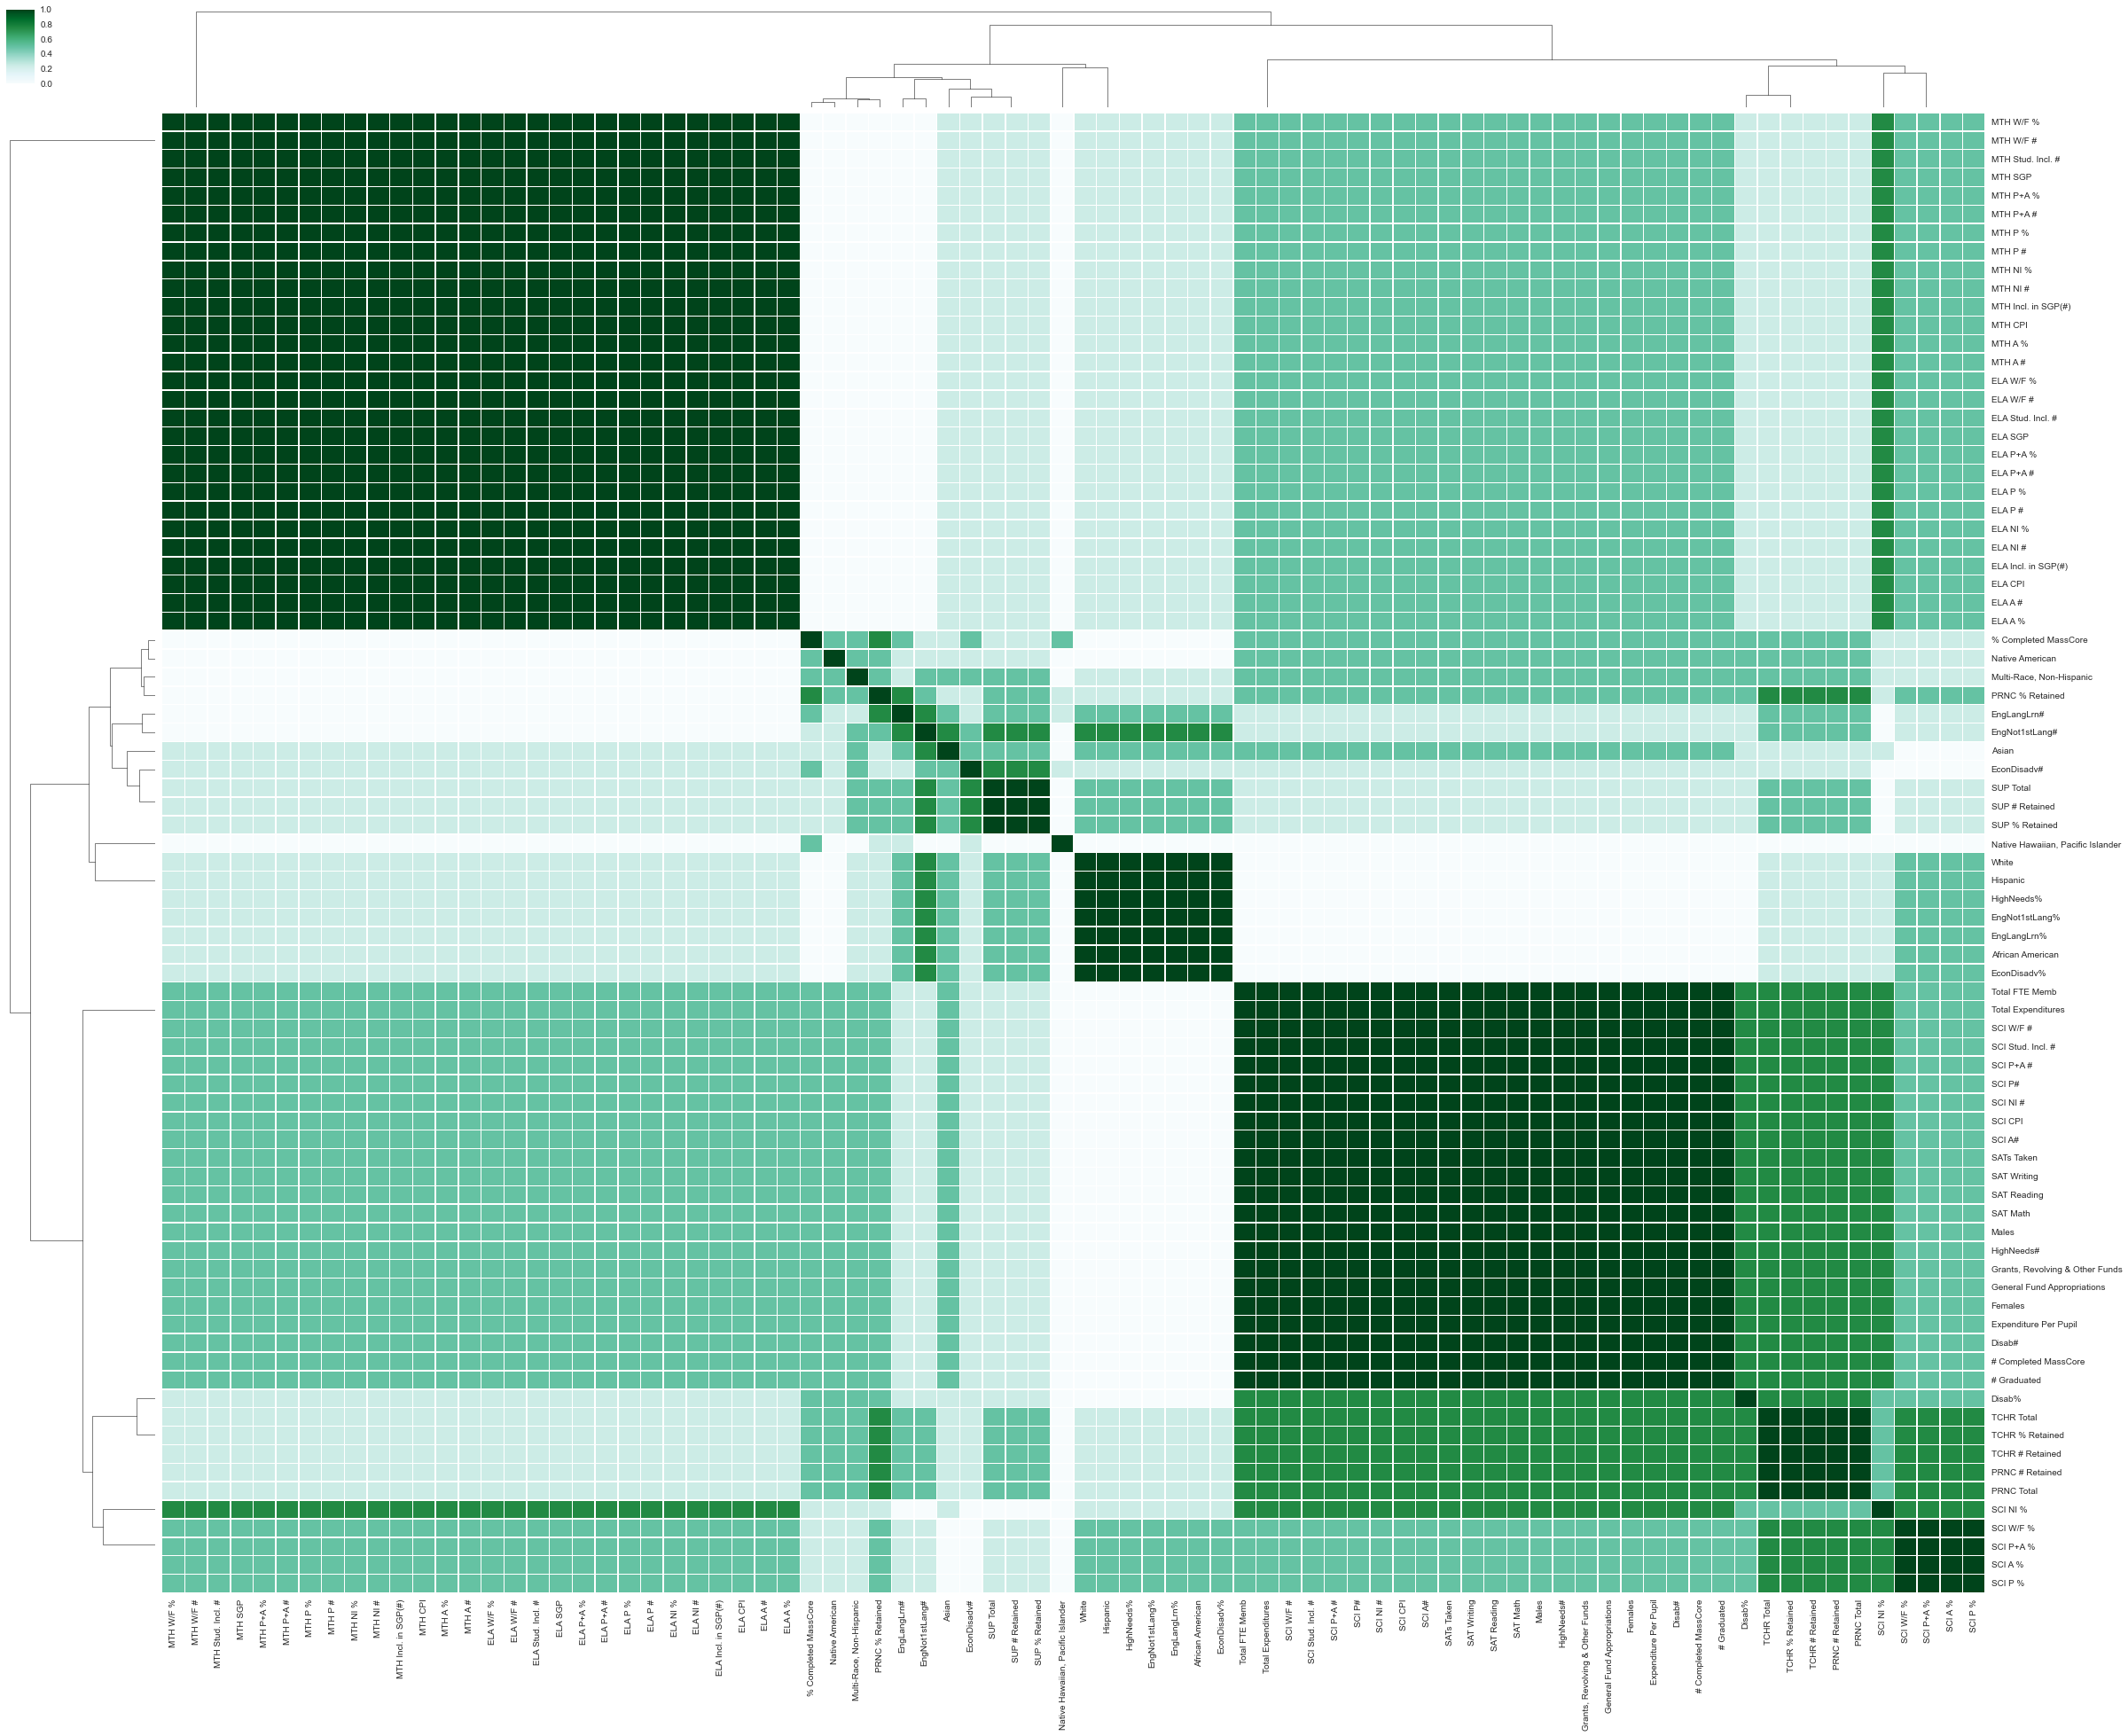

In [4]:
schools0.heatmap(schools0.q("""ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g"""))

Let's pull out just the MCAS test results from the above:

BQL [
ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "schools0_cc" 
WHERE (name0 LIKE "%MTH%" OR name0 LIKE "%SCI%" OR name0 LIKE "%ELA%") 
 AND (name1 LIKE "%MTH%" OR name1 LIKE "%SCI%" OR name1 LIKE "%ELA%");
] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


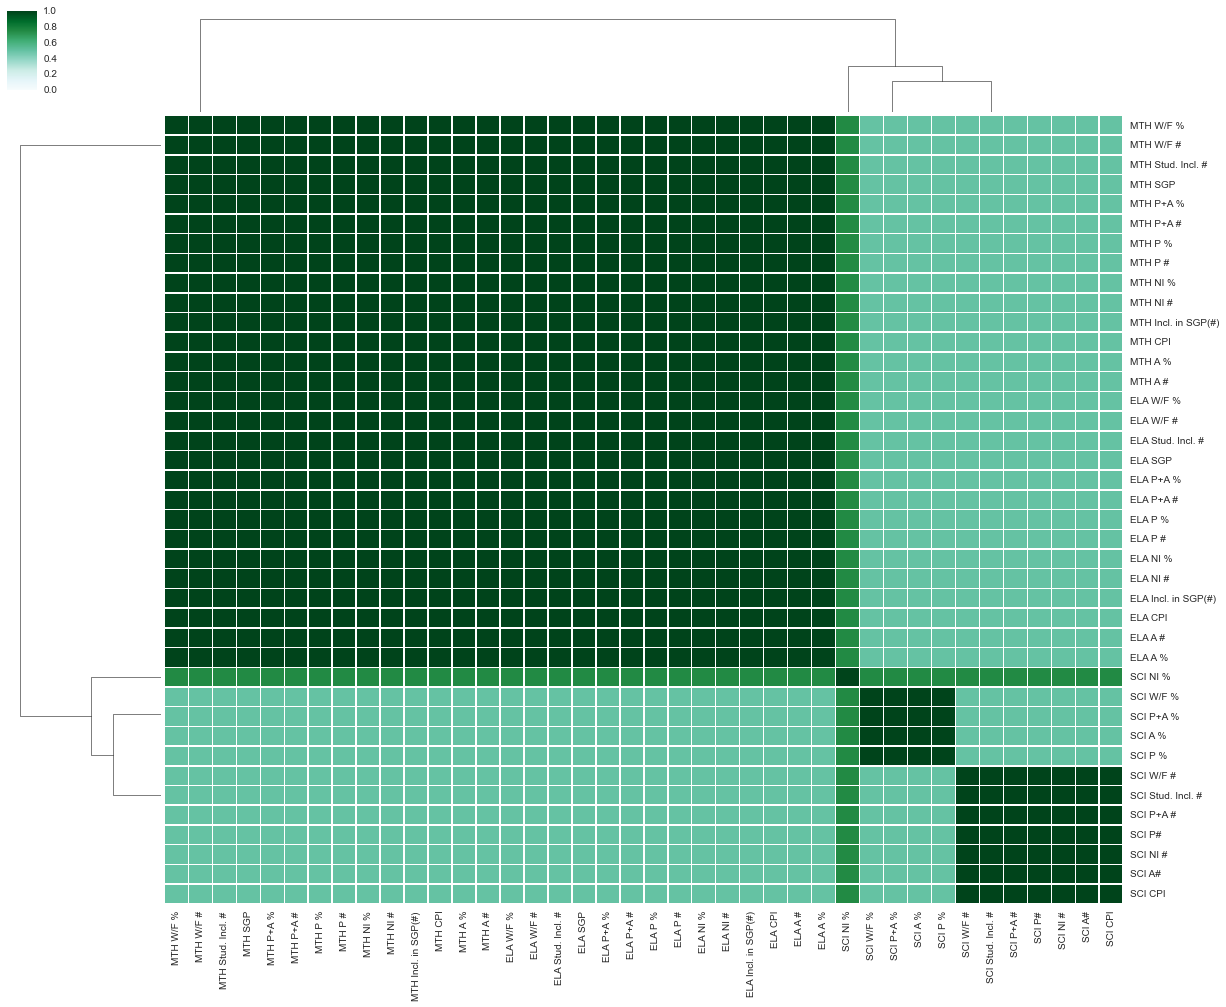

In [5]:
schools0.heatmap("""
ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g 
WHERE (name0 LIKE "%MTH%" OR name0 LIKE "%SCI%" OR name0 LIKE "%ELA%") 
  AND (name1 LIKE "%MTH%" OR name1 LIKE "%SCI%" OR name1 LIKE "%ELA%");
""")

In [6]:
schools0.quick_describe_variables()

BQL [SELECT * FROM "schools0"] ()

,name,stattype,unique,top,freq,mean,std,min,25%,50%,75%,max,count,hist
0,DISTRICT,ignored,405,Ma Academy for Math and Science,1,None,None,None,None,None,None,None,405,None
1,African American,numerical,None,None,None,8.54642,16.0535,0,1,2.2,6.2,80.7,405,None
2,Asian,numerical,None,None,None,4.0084,5.70852,0,1,1.9,4.5,41.2,405,None
3,Hispanic,numerical,None,None,None,12.9714,18.2415,0,3,5.2,13.5,98.7,405,None
4,White,numerical,None,None,None,71.0289,28.4872,0,62.5,83.2,90.5,100,405,None
5,Native American,numerical,None,None,None,0.27679,0.516993,0,0,0.1,0.3,5.9,405,None
6,"Native Hawaiian, Pacific Islander",categorical,None,None,None,0.102469,0.225577,0,0,0,0.1,2.7,405,None
7,"Multi-Race, Non-Hispanic",numerical,None,None,None,3.06074,2.14479,0,1.7,2.6,4,17.7,405,None
8,Males,numerical,None,None,None,50.6773,3.76725,29.5,49.6,50.9,52.1,68.1,405,None
9,Females,numerical,None,None,None,49.323,3.76754,31.9,47.9,49.1,50.4,70.5,405,None


**Why is `MTH SGP` listed as categorical, but `SCI SGP` as ignored?**

We ignore categorical columns that have so few observations per member that bayesdb would have a hard time learning anything about each category. Unlike numeric variables, each value in a categorical is treated as completely orthogonal to every other value. For many categoricals this is not naturally the case (there may be hierarchies, etc.) but we do not model that behavior with the default models. There are similarly many possible types of numerical model (student-t distributed, normal, Poisson, multinomial, etc.) and currently only normal (Gaussian) is available with the default models. Finer grained types are beyond the scope of this segment of the tutorial.

**Why are so many seemingly numeric fields listed as categorical?**

In many of the descriptions above, the values are numeric enough for the pandas library to yield a mean and other numeric summary characteristics, but bayesdb guesses them as categorical anyway. 

We guess categorical unless we can read all the values in the column as numbers. We also guess categorical for numeric data if there are so few distinct numbers that they might be better treated as categorical anyway, because their numeric proximity is more misleading than helpful.

**Nullifying values**

Looking back at the data, we see a likely culprit: many 'N/A' and '#N/A' values. We should transform the dataset to nullify these, instead of considering them a separate category.  No need to change the csv, but we will need to reset the generator (e.g. DROP GENERATOR...), because we will want to recreate it with the same generator name `%g`.

In [7]:
schools1 = Population('schools1', csv_path=datafile)
schools1.nullify('N/A')
schools1.nullify('#N/A')
schools1.q("""DROP GENERATOR %g""")
# Try guessing again:
schools1.q("""
CREATE GENERATOR %g IF NOT EXISTS FOR %t 
USING crosscat( "SCI SGP" CATEGORICAL, GUESS(*) )
""")

BQL [SELECT * FROM bayesdb_generator] ()

BQL [SELECT COUNT(*) FROM "schools1"] ()

BQL [
 CREATE GENERATOR "schools1_cc" IF NOT EXISTS FOR "schools1" USING crosscat( GUESS(*) )] ()

BQL [DROP GENERATOR "schools1_cc"] ()

BQL [
CREATE GENERATOR "schools1_cc" IF NOT EXISTS FOR "schools1" 
USING crosscat( "SCI SGP" CATEGORICAL, GUESS(*) )
] ()

""


Notice the MetaModeling Language (MML) snippet `( "SCI SGP" CATEGORICAL, GUESS(*) )` above. Within `categorical` or `numerical`, you can set the statistical types of each variable explicitly there, with comma-separated pairs of name and statistical type, and leave the `GUESS(*)` at the end to guess the rest. For now, let us explore how to help BayesDB guess the right statistical type between `categorical` and `numerical`.

In [8]:
schools1.quick_describe_variables()

BQL [SELECT * FROM "schools1"] ()

,name,stattype,unique,top,freq,mean,std,min,25%,50%,75%,max,count,hist
0,DISTRICT,ignored,405,Ma Academy for Math and Science,1,None,None,None,None,None,None,None,405,None
1,African American,numerical,None,None,None,8.54642,16.0535,0,1,2.2,6.2,80.7,405,None
2,Asian,numerical,None,None,None,4.0084,5.70852,0,1,1.9,4.5,41.2,405,None
3,Hispanic,numerical,None,None,None,12.9714,18.2415,0,3,5.2,13.5,98.7,405,None
4,White,numerical,None,None,None,71.0289,28.4872,0,62.5,83.2,90.5,100,405,None
5,Native American,numerical,None,None,None,0.27679,0.516993,0,0,0.1,0.3,5.9,405,None
6,"Native Hawaiian, Pacific Islander",categorical,None,None,None,0.102469,0.225577,0,0,0,0.1,2.7,405,None
7,"Multi-Race, Non-Hispanic",numerical,None,None,None,3.06074,2.14479,0,1.7,2.6,4,17.7,405,None
8,Males,numerical,None,None,None,50.6773,3.76725,29.5,49.6,50.9,52.1,68.1,405,None
9,Females,numerical,None,None,None,49.323,3.76754,31.9,47.9,49.1,50.4,70.5,405,None


But there are still columns that are categorical that shouldn't be, like "EngNot1stLang#" and "Total Expenditures". Why is that? Let's examine just one column.

In [9]:
schools1.q("""SELECT "EngNot1stLang#" FROM %t;""")

BQL [SELECT "EngNot1stLang#" FROM "schools1";] ()

,EngNot1stLang#
0,345
1,91
2,31
3,882
4,15
5,12
6,197
7,269
8,41
9,56


You might notice, right at the bottom, the value "12,018". That sure looks numerical, but has a comma in it. Oops.
Let's fix this in a dataframe, and try again. The convert_where_possible function below converts numbers formatted that way. It also takes care of the special values we fixed above, and a few more. We apply it to the table in the next step, and then create a new "schools2" from the resulting pandas.DataFrame.

**Exercise 1**

Please post your solution to slack, either in the iap2016 room, or privately to a staff member. If you have questions or comments, or want to shape future labs a different way, please also post those.

Modify convert_where_possible below to fix values in Total Expenditures to ensure that they are numerical.  There is an example at the bottom of the cell to make it quick for you to check whether you've fixed the processing of dollar amounts.

In [10]:
import locale
import numpy as np
locale.setlocale(locale.LC_NUMERIC, '')
import re
def convert_where_possible(value):
    try:
        if isinstance(value, str) or isinstance(value, unicode):
            if value in ('', 'None', 'none', 'N/A', '#N/A', 'NaN', 'nan'):
                return None
            if not re.search(r'\d', value):
                return value
            return locale.atof(value) 
        elif value is None or np.isnan(float(value)):
            return None
        else:
            return value
    except (ValueError, TypeError) as e:
        print 'Cannot convert [%s]/%s because [%s]' % (value, value.__class__, e)
        return value

import pandas as pd
playdf = pd.DataFrame({'Leave be': ['hello world', '3%', 2, None],
                       'Make numeric': ['21,191', '$3,052,103', '2,003.80', u'2.8'],
                       'Nulls': ['NaN', 'None', 'N/A', '#N/A']})
playdf.applymap(convert_where_possible)

Cannot convert [3%]/<type 'str'> because [invalid literal for float(): 3%]
Cannot convert [3%]/<type 'str'> because [invalid literal for float(): 3%]
Cannot convert [$3,052,103]/<type 'str'> because [could not convert string to float: $3052103]


,Leave be,Make numeric,Nulls
0,hello world,21191,None
1,3%,"$3,052,103",None
2,2,2003.8,None
3,None,2.8,None


In [11]:
df = schools0.q("""SELECT * FROM %t""")
df = df.applymap(convert_where_possible)
df.shape

BQL [SELECT * FROM "schools0"] ()

Cannot convert [$24,027,141]/<type 'unicode'> because [could not convert string to float: $24027141]
Cannot convert [$38,553,800]/<type 'unicode'> because [could not convert string to float: $38553800]
Cannot convert [$13,827,824]/<type 'unicode'> because [could not convert string to float: $13827824]
Cannot convert [$17,128,450]/<type 'unicode'> because [could not convert string to float: $17128450]
Cannot convert [$51,830,624]/<type 'unicode'> because [could not convert string to float: $51830624]
Cannot convert [$29,496,781]/<type 'unicode'> because [could not convert string to float: $29496781]
Cannot convert [$23,615,972]/<type 'unicode'> because [could not convert string to float: $23615972]
Cannot convert [$28,509,009]/<type 'unicode'> because [could not convert string to float: $28509009]
Cannot convert [$86,403,709]/<type 'unicode'> because [could not convert string to float: $86403709]
Cannot convert [$59,336,557]/<type 'unicode'> because [could not convert string to float: $

(405, 83)

In [12]:
schools2 = Population('schools2', df=df, bdb_path='schools2.bdb')
schools2.quick_describe_variables()

BQL [SELECT * FROM bayesdb_generator] ()

,name,stattype,unique,top,freq,mean,std,min,25%,50%,75%,max,count,hist
0,DISTRICT,ignored,405,Ma Academy for Math and Science,1,None,None,None,None,None,None,None,405,None
1,African American,numerical,None,None,None,8.54642,16.0535,0,1,2.2,6.2,80.7,405,None
2,Asian,numerical,None,None,None,4.0084,5.70852,0,1,1.9,4.5,41.2,405,None
3,Hispanic,numerical,None,None,None,12.9714,18.2415,0,3,5.2,13.5,98.7,405,None
4,White,numerical,None,None,None,71.0289,28.4872,0,62.5,83.2,90.5,100,405,None
5,Native American,numerical,None,None,None,0.27679,0.516993,0,0,0.1,0.3,5.9,405,None
6,"Native Hawaiian, Pacific Islander",categorical,None,None,None,0.102469,0.225577,0,0,0,0.1,2.7,405,None
7,"Multi-Race, Non-Hispanic",numerical,None,None,None,3.06074,2.14479,0,1.7,2.6,4,17.7,405,None
8,Males,numerical,None,None,None,50.6773,3.76725,29.5,49.6,50.9,52.1,68.1,405,None
9,Females,numerical,None,None,None,49.323,3.76754,31.9,47.9,49.1,50.4,70.5,405,None


In [13]:
if len(schools2.analysis_status()) == 0:
    schools2.analyze(models=4, minutes=1)
schools2.analysis_status()

BQL [SELECT iterations FROM bayesdb_generator_model
 WHERE generator_id = (
 SELECT id FROM bayesdb_generator WHERE name = ?)] ('schools2_cc',)

BQL [SELECT iterations FROM bayesdb_generator_model
 WHERE generator_id = (
 SELECT id FROM bayesdb_generator WHERE name = ?)] ('schools2_cc',)

,count of model instances
iterations,
10,36
29,4


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "schools2_cc"] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


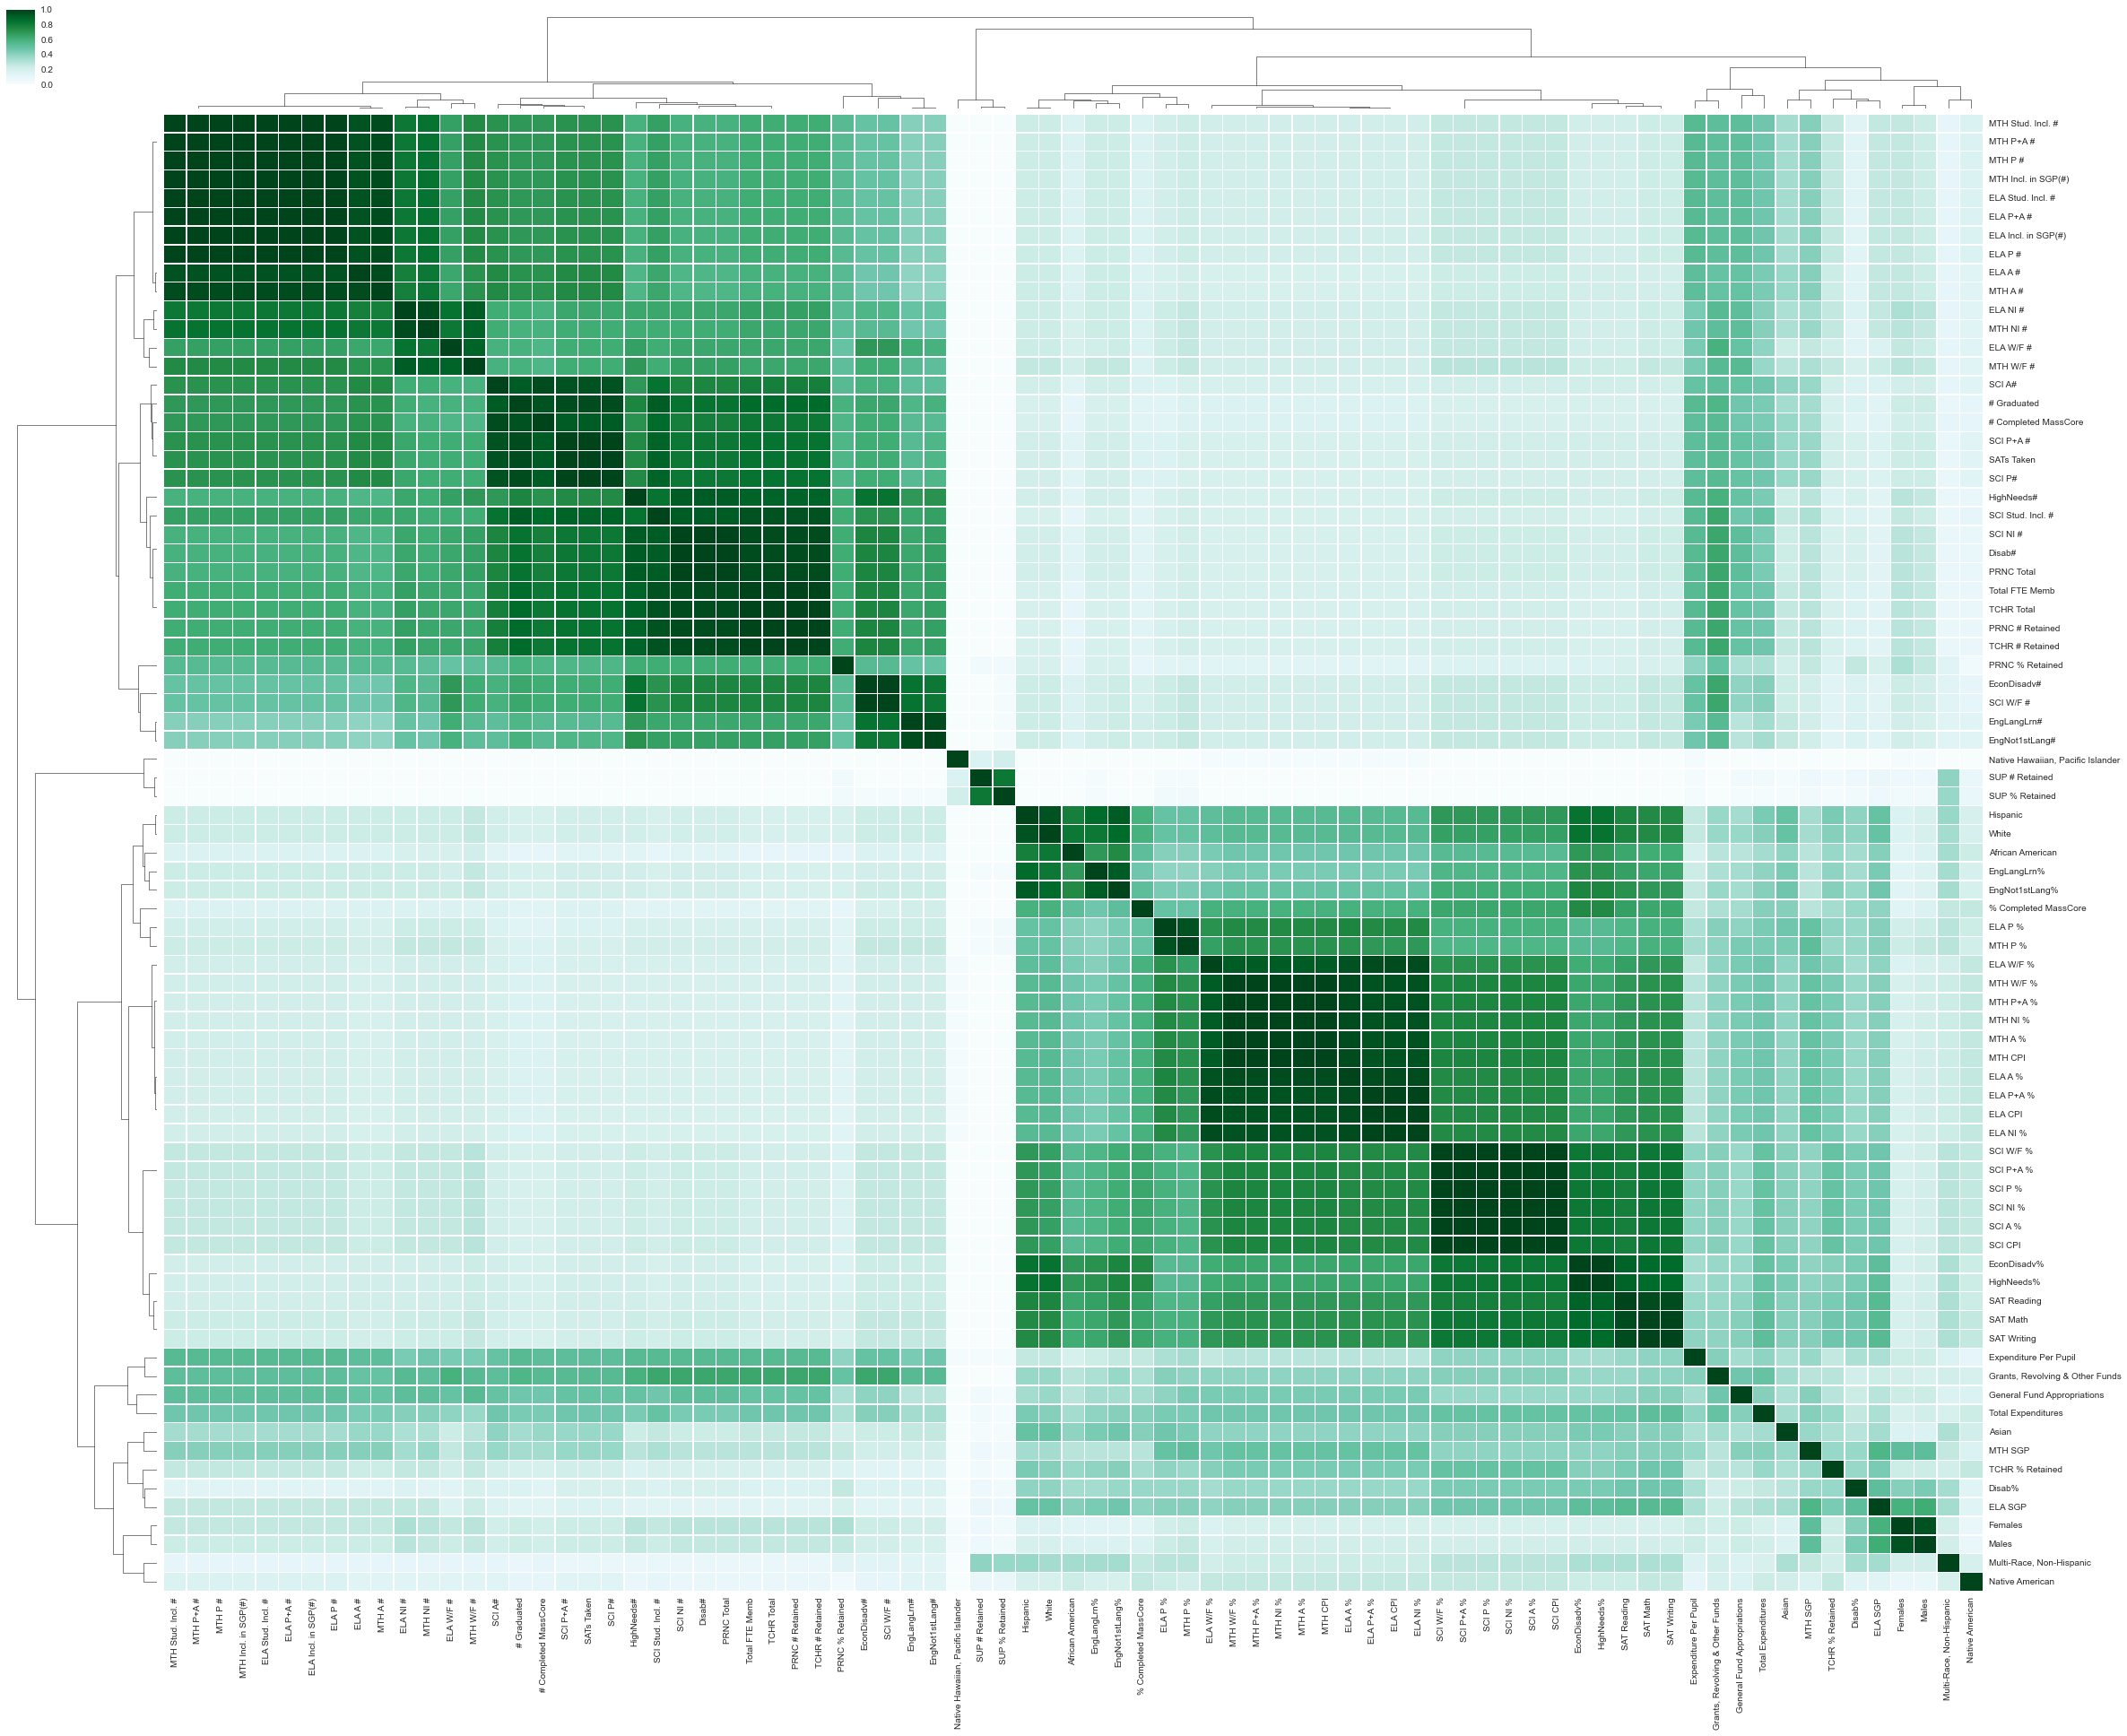

In [14]:
schools2.heatmap(schools2.q("""ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g"""))

Our modeling choices have made a big difference in the ways that columns are categorized!

In [15]:
if len(schools2.analysis_status()) == 1:
    schools2.analyze(models=40, iterations=20)
schools2.analysis_status()

BQL [SELECT iterations FROM bayesdb_generator_model
 WHERE generator_id = (
 SELECT id FROM bayesdb_generator WHERE name = ?)] ('schools2_cc',)

BQL [SELECT iterations FROM bayesdb_generator_model
 WHERE generator_id = (
 SELECT id FROM bayesdb_generator WHERE name = ?)] ('schools2_cc',)

,count of model instances
iterations,
10,36
29,4


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "schools2_cc"] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


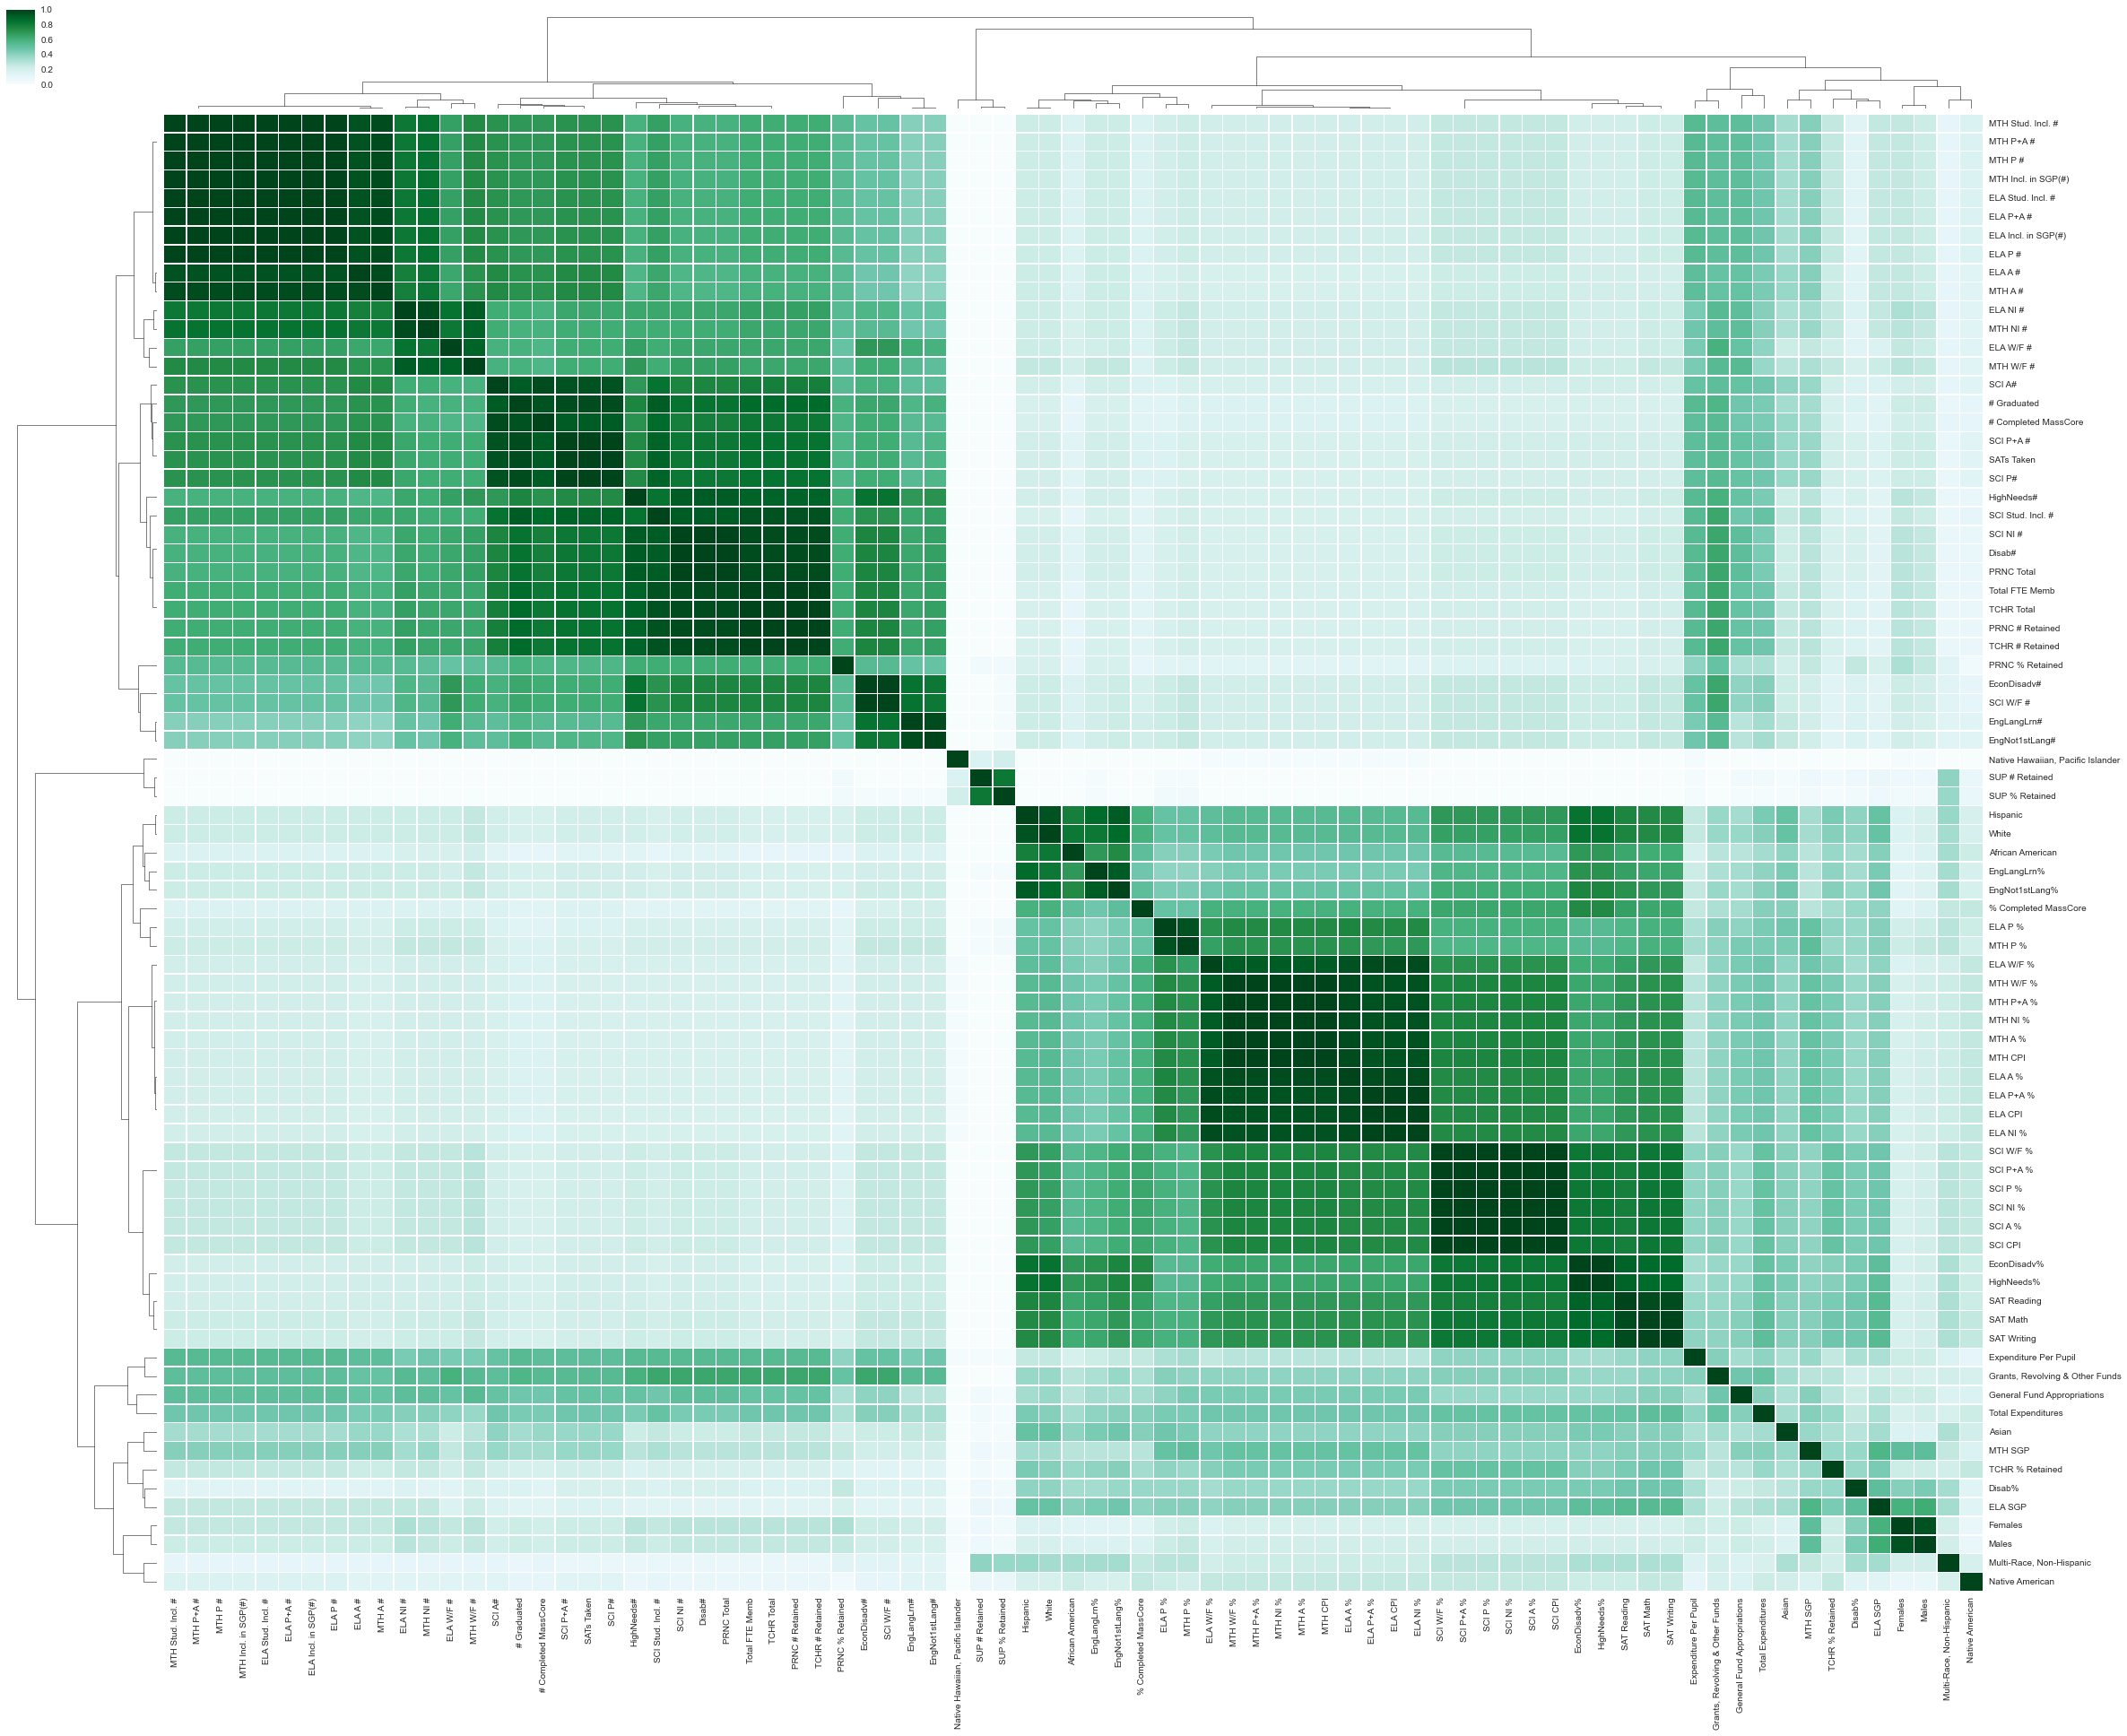

In [16]:
schools2.heatmap(schools2.q("""ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g"""))

As we do more analysis, seeing that the heatmap doesn't change is suggestive that the model has converged.
We will cover model quality measures in the next lab.

For each of the following questions, write a paragraph or two, and **post it to slack**, either in private chat to one of the staff, or in the public iap2016 room. Obviously this is not for credit, but doing so gives us (and perhaps your peers, if you choose to share) an opportunity to respond to your questions and ideas, and helps us shape the upcoming lectures.

**Discuss!** What dependencies and independencies do you see? Do they make sense to you intuitively?

**Discuss!** What do you expect the tradeoff to be like between number of models and iterations that each model has run? According to your intuition, are there advantages or disadvantages to running all models for the same number of iterations?

**Discuss!** How does the meaning of the colors change as we run more models for more iterations?



Ultimately, our goal was to be able to ask questions about this population, using the generative population model that we have built. Let's take a closer look at some columns.

In [17]:
help(schools2.quick_explore_vars)

Help on method bdbcontrib.recipes.quick_explore_vars in bdbcontrib.recipes:

bdbcontrib.recipes.quick_explore_vars(self, *args, **kwargs) method of bdbcontrib.population.Population instance
    wrapped as population.quick_explore_vars(varnames, plotfile=None, nsimilar=20)
    
    Show dependence probabilities and neighborhoods based on those.
    
      varnames: list of strings
          At least two column names to look at dependence probabilities of,
          and to explore neighborhoods of.
      nsimilar: positive integer
          The size of the neighborhood to explore.



/Users/probcomp/GoogleDrive/ProbComp/venv-2.7.11-0.1.4/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/probcomp/GoogleDrive/ProbComp/venv-2.7.11-0.1.4/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


BQL [ESTIMATE DEPENDENCE PROBABILITY
 FROM PAIRWISE COLUMNS OF schools2_cc
 FOR "SAT Math", "SAT Reading", "SAT Writing";] ()

Pairwise dependence probability for: "SAT Math", "SAT Reading", "SAT Writing"
   genid        name0        name1  value
7      1     SAT Math  SAT Writing  1.000
1      1  SAT Reading  SAT Writing  0.975
6      1     SAT Math  SAT Reading  0.975




BQL [ESTIMATE *, DEPENDENCE PROBABILITY WITH "SAT Math"
 AS "Probability of Dependence with SAT Math"
 FROM COLUMNS OF schools2_cc
 ORDER BY "Probability of Dependence with SAT Math"
 DESC LIMIT 20;] ()

BQL [ESTIMATE DEPENDENCE PROBABILITY
 FROM PAIRWISE COLUMNS OF schools2_cc
 FOR "SAT Writing", "SAT Math", "SAT Reading", "HighNeeds%", "EconDisadv%", "SCI P+A %", "SCI A %", "SCI P %", "SCI NI %", "SCI W/F %", "SCI CPI", "Hispanic", "White", "MTH P+A %", "MTH A %", "MTH NI %", "MTH W/F %", "MTH CPI", "ELA P+A %", "ELA A %";] ()

Pairwise dependence probability of SAT Math with its strongest dependents:
           name  Probability of Dependence with SAT Math
0   SAT Writing                                    1.000
1      SAT Math                                    1.000
2   SAT Reading                                    0.975
3    HighNeeds%                                    0.875
4   EconDisadv%                                    0.875
5     SCI P+A %                                    0.825
6       SCI A %                                    0.825
7       SCI P %                                    0.825
8      SCI NI %                                    0.825
9     SCI W/F %                                    0.825
10      SCI CPI                                    0.825
11     Hispanic                                    0.750
12        White                                    0.750
13    MTH P+A %                                    0.725
14      MTH A %                                    0.725
15     MTH NI

BQL [ESTIMATE *, DEPENDENCE PROBABILITY WITH "SAT Reading"
 AS "Probability of Dependence with SAT Reading"
 FROM COLUMNS OF schools2_cc
 ORDER BY "Probability of Dependence with SAT Reading"
 DESC LIMIT 20;] ()

BQL [ESTIMATE DEPENDENCE PROBABILITY
 FROM PAIRWISE COLUMNS OF schools2_cc
 FOR "SAT Reading", "SAT Writing", "SAT Math", "HighNeeds%", "EconDisadv%", "SCI P+A %", "SCI A %", "SCI P %", "SCI NI %", "SCI W/F %", "SCI CPI", "Hispanic", "White", "EngNot1stLang%", "MTH P+A %", "MTH A %", "MTH NI %", "MTH W/F %", "MTH CPI", "ELA P+A %";] ()

Pairwise dependence probability of SAT Reading with its strongest dependents:
              name  Probability of Dependence with SAT Reading
0      SAT Reading                                       1.000
1      SAT Writing                                       0.975
2         SAT Math                                       0.975
3       HighNeeds%                                       0.900
4      EconDisadv%                                       0.900
5        SCI P+A %                                       0.800
6          SCI A %                                       0.800
7          SCI P %                                       0.800
8         SCI NI %                                       0.800
9        SCI W/F %                                       0.800
10         SCI CPI                                       0.800
11        Hispanic                                       0.775
12           White                                       0.775
13  EngNot1stLang%                      

BQL [ESTIMATE *, DEPENDENCE PROBABILITY WITH "SAT Writing"
 AS "Probability of Dependence with SAT Writing"
 FROM COLUMNS OF schools2_cc
 ORDER BY "Probability of Dependence with SAT Writing"
 DESC LIMIT 20;] ()

BQL [ESTIMATE DEPENDENCE PROBABILITY
 FROM PAIRWISE COLUMNS OF schools2_cc
 FOR "SAT Writing", "SAT Math", "SAT Reading", "HighNeeds%", "EconDisadv%", "SCI P+A %", "SCI A %", "SCI P %", "SCI NI %", "SCI W/F %", "SCI CPI", "Hispanic", "White", "MTH P+A %", "MTH A %", "MTH NI %", "MTH W/F %", "MTH CPI", "ELA P+A %", "ELA A %";] ()

Pairwise dependence probability of SAT Writing with its strongest dependents:
           name  Probability of Dependence with SAT Writing
0   SAT Writing                                       1.000
1      SAT Math                                       1.000
2   SAT Reading                                       0.975
3    HighNeeds%                                       0.875
4   EconDisadv%                                       0.875
5     SCI P+A %                                       0.825
6       SCI A %                                       0.825
7       SCI P %                                       0.825
8      SCI NI %                                       0.825
9     SCI W/F %                                       0.825
10      SCI CPI                                       0.825
11     Hispanic                                       0.750
12        White                                       0.750
13    MTH P+A %                                       0.725
14      MTH A %       

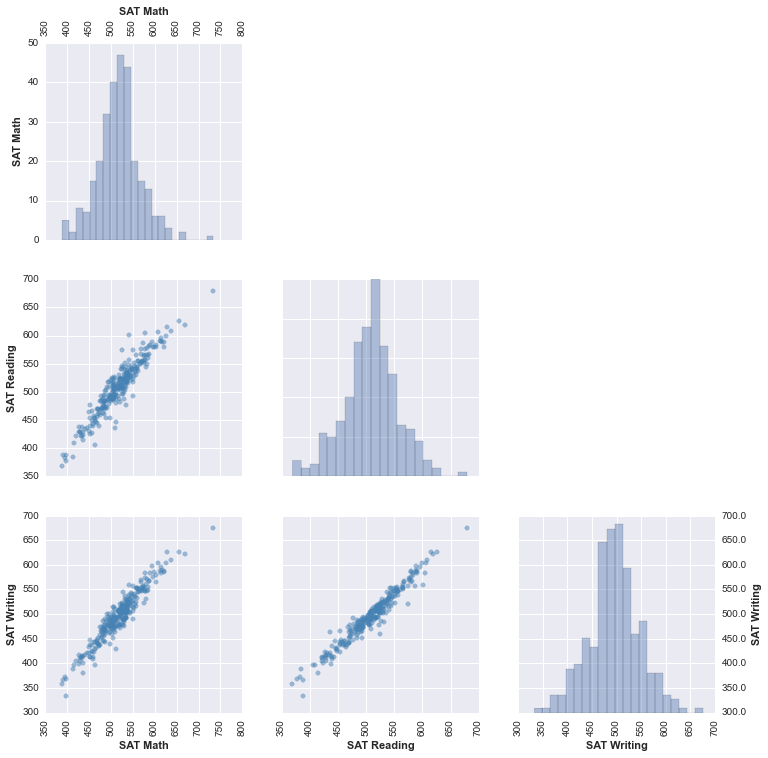

In [18]:
schools2.quick_explore_vars(['SAT Math', 'SAT Reading', 'SAT Writing'])

Above, we see that the SAT scores are highly correlated (at the district level), and not only likely to be dependent. It's somewhat saddening that some of the closest variables are EconDisadv% and HighNeeds%, because it suggests that these tests, as they are used in giving students opportunities for education, may bolster the advantages accruing to the wealthy, rather than leveling the playing field, as a test of *aptitude* might be expected to.

Notice that quick_explore_vars shows the BQL that it is executing for you. We hope that having these examples will help you formulate more kinds of BQL queries on your own.

**Exercise 2** Confirm or deny that hypothesis. What *is* the relationship between SAT scores and those poverty indicators? If you had a district with low SAT scores, can you tell if it is most likely the result of those indicators? Of expenditures? Of staff retention?

While we are working on answering questions like 

    q('ESTIMATE PROBABILITY OF ("SAT Reading" > 400) GIVEN ("EconDisadv%">50) FROM %g LIMIT 1;'

we cannot yet handle inequalities. (Come help!)

As we did in Lab 1, we can SIMULATE many examples and choose those where "SAT Reading" > 400, and do rejection sampling for the GIVEN portion. Feel free to do that as an exercise.

And we can always discretize the data, and ask similar questions of those now-categorical columns. EconDisadv% > 50 has a name in the parlance of education politics. Schools (not districts, but close enough) with that property are called "Title I" schools, referencing a relevant law.

In [19]:
df['title1']=[poverty > 50 for poverty in df['EconDisadv%']]
df['EconDisadv%'].head(10), df['title1'].head(10)

(0    30.5
 1    17.2
 2    29.3
 3     4.0
 4    17.5
 5    36.4
 6     6.1
 7    25.3
 8    53.3
 9    17.6
 Name: EconDisadv%, dtype: float64, 0    False
 1    False
 2    False
 3    False
 4    False
 5    False
 6    False
 7    False
 8     True
 9    False
 Name: title1, dtype: bool)

**Exercise 3**
Add another discretization, and estimate conditional probability on that basis: 

    ESTIMATE PROBABILITY OF (title1='True') GIVEN ("your new variable here"='value') FROM %g LIMIT 1;

Then build schools3 with the new df, analyze it, and as a conditional probability question.

**Take-Home Project:** Explore! Choose sets of variables whose relationships interest you, and write a paragraph or two about what you've learned.

--------------------------------------------

Copyright (c) 2010-2016, MIT Probabilistic Computing Project

Licensed under Apache 2.0 (edit cell for details).

<!--
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
-->